# Deep Learning: Mastering Neural Networks - Module 5: Transfer Learning in Pytorch

In Module 4 we first implemented our own Deep CNN for image classification on the MNIST dataset. We saw that by using Convolutional Layers we could improve the performance over a standard feedword network.

Although we saw good performance on MNIST, this dataset isn't very representative of real world computer vision problems that we may want to solve. A popular dataset that is more representative of every day objects is [ImageNet](https://www.image-net.org/) which contains labeled examples of thousands of different classes.

Because ImageNet contains so many different classes of images, the simple CNN that we created in the previous module would not perform very well on the different classification tasks associated with the dataset. Additionally, due to the sheer number of images, training on the entire dataset would take a significant amount of computing resources.

Thankfully for us, Pytorch has large models built in that have already been trained on the entirety of ImageNet or other similar large datasets! We leverage the features that have been learned on these datasets and use these pre-trained models to complete our own image classification task.

Using a pre-trained network from one dataset to perform a different task on a separate dataset is known as Transfer Learning and we will take you through an example in this notebook!

Note: Training these large models can take a significant amount of time. Our team has already run these notebooks and left the output for you to examine so don't feel the need to train them yourself. However, if you want to run cells from later in the notebook, you must run the earlier cells. Even though the output is persisted, the internal state of the program is not.

## Model Selection

Pytorch comes with many different pretrained models built in. The full list of vision related can be found in the Pytorch Documentation [here](https://pytorch.org/vision/0.8/models.html).

For our task, we will select one of the models that is used for Image Classification, however transfer learning can work for many different types of problems and is not limited to Image Classification.

We have chosen the VGG11 net for our task in this notebook. VGG11 is first introduced in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" by Karen Simonyan and Andrew Zisserman which can be found [here](https://arxiv.org/abs/1409.1556).

In the module we saw examples featuring VGG16 which is a very similar model that comes from the same paper. We chose VGG11 for our example as it is a slightly smaller network (11 Convolutional layers as opposed to 16) which results in faster training times while still demonstrating the power of transfer learning.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Imports a VGG-16 model pretrained on ImageNet
vgg11 = torchvision.models.vgg11(pretrained=True, progress=True)
vgg11

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

We can see that VGG11 is a ginormous network, and training it on ImageNet would take an extremely long amount of time.

Thankfully, we can import this entire pretrained network with 1 line of Python!

Now that we have a fully trained network, we can augment our dataset to be compatible with the architecture and then perform fine-tuning to adapt VGG11 to our new task.

## Dataset

For our dataset we have chosen the German Traffic Sign Recognition Benchmark (GTSRB) dataset (https://benchmark.ini.rub.de/gtsrb_news.html). This dataset is easily available through Pytorch (just like MNIST and FashionMNIST) and contains almost 40,000 images spanning over 40 classes.

For our specific transfer learning task, we will perform classification on this dataset!

In [ ]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224]),
    transforms.Normalize([0], [1])
    ])
# Must resize to VGG11 input size
gtsrb_train = torchvision.datasets.GTSRB('', split="train", transform = transform, download=True)

# We will split out train dataset into train and validation!
gtsrb_train, gtsrb_val = torch.utils.data.random_split(gtsrb_train, [int(np.floor(len(gtsrb_train)*0.75)), int(np.ceil(len(gtsrb_train)*0.25))])

gtsrb_test = torchvision.datasets.GTSRB('', split="test", transform = transform, download=True)

In [ ]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(gtsrb_train, batch_size=batch_size),
               'val': DataLoader(gtsrb_val, batch_size=batch_size),
               'test': DataLoader(gtsrb_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(gtsrb_train),
                 'val': len(gtsrb_val),
                 'test': len(gtsrb_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 19980, 'val': 6660, 'test': 12630}


## Visualization

Now let's visualize our dataset so we can see some of the images and classes we are working with.

In [ ]:
# First determine the total number of classes:
gtsrb_labels = set()
for _, labels in dataloaders["train"]:
    for label in labels:
        gtsrb_labels.add(label.item())
print(len(gtsrb_labels))
print(gtsrb_labels)


43
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}


In [ ]:
# plot a digit ground truth and autoencoding
def view_gtsrb_class(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            # ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().permute((1,2,0))
            plt.imshow(input)
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

def view_gtsrb_all():
    for i in range(43):
        view_gtsrb_class(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


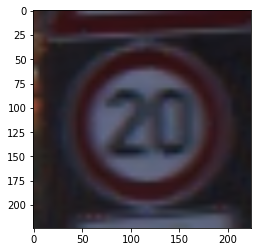

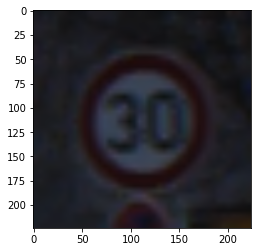

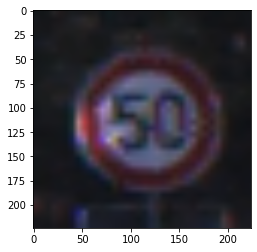

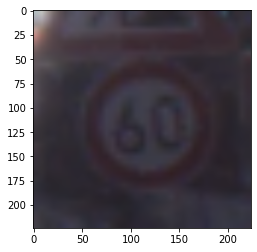

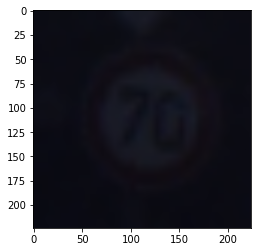

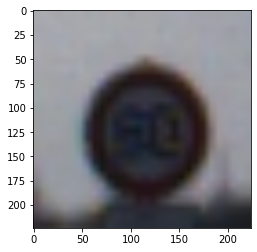

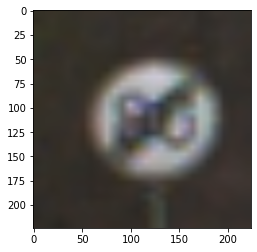

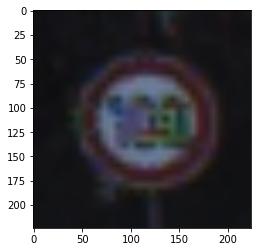

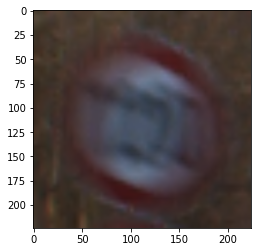

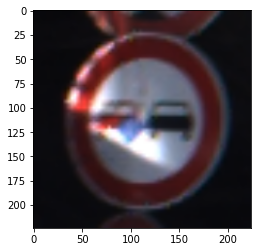

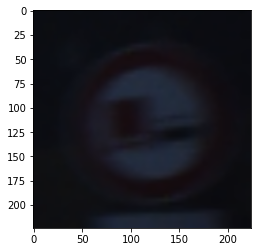

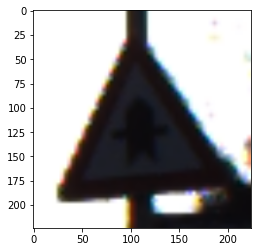

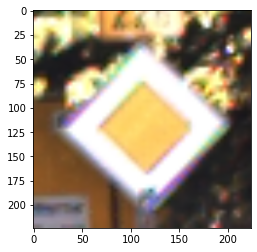

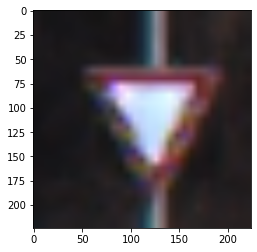

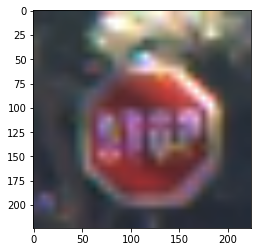

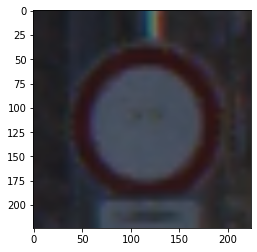

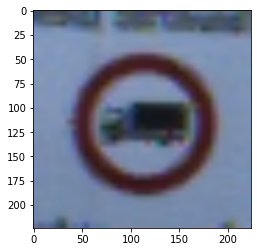

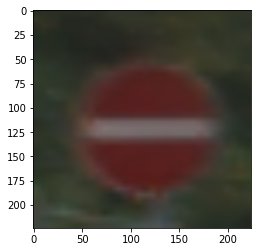

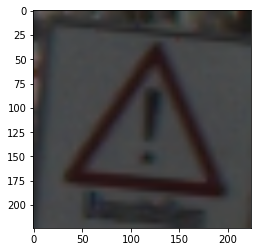

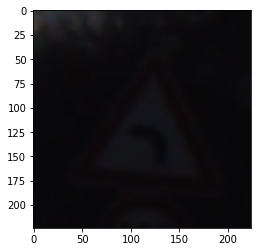

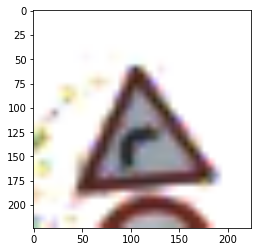

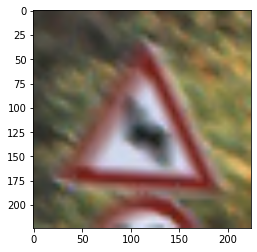

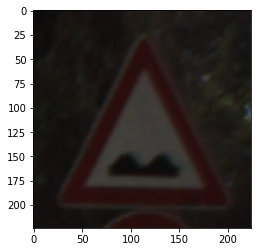

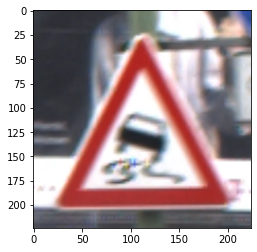

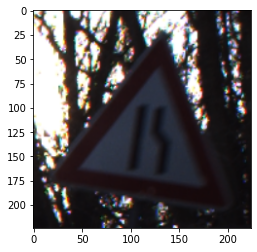

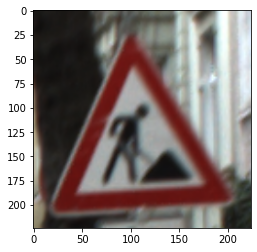

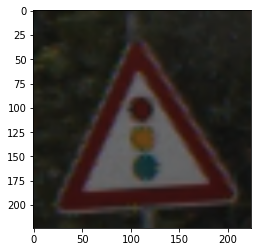

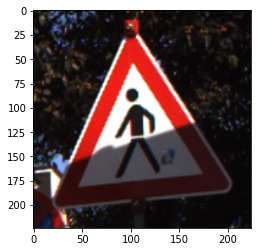

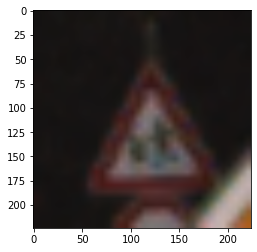

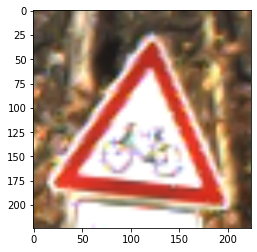

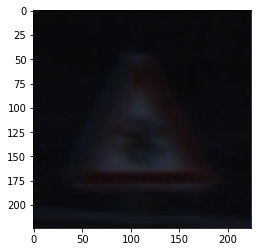

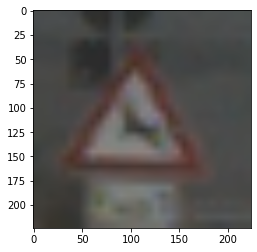

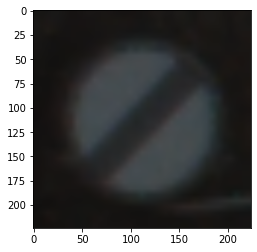

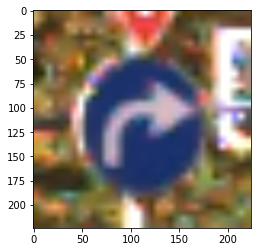

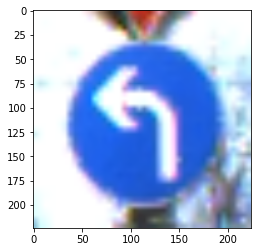

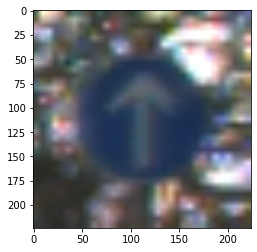

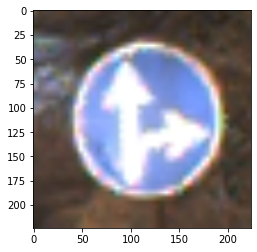

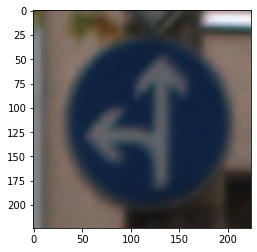

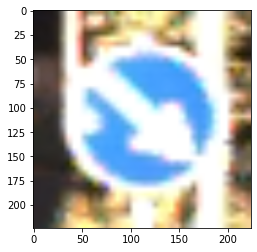

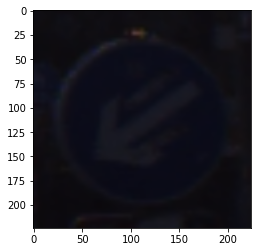

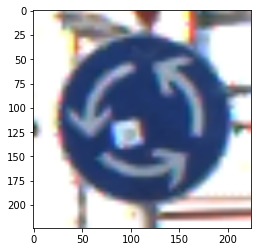

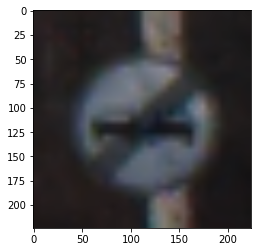

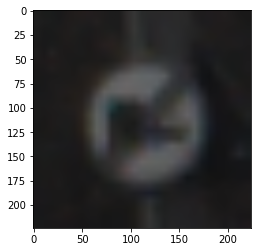

In [ ]:
view_gtsrb_all()

## Augmenting the Model

Now that we have investigated our dataset, we want to modify the original VGG11 architecture to be able to classify our new images correctly. During the data import phase we already resized our input images to the correct 224x224x3 dimension so VGG11 will be able to handle our input. However, in the original VGG11 architecture, the output layer had a size of 1000 which does not match our 43 different classes of traffic signs. In order to account for this, we will remove the last layer and replace it with a layer of size 43.

In [ ]:
# Freeze the weights of the network
for param in vgg11.parameters():
    param.requires_grad = False
# Swap the last layer to contain the same number of outputs as classes in our dataset
# New layers have their weights unfrozen by default
vgg11.classifier[6] = nn.Linear(vgg11.classifier[6].in_features, len(gtsrb_labels))
vgg11.to(device)
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## Training the Model

In transfer learning, we will split our training process into two distinct phases.

First, we will freeze the weights of the pre-trained network and focus on tuning just the last classification layer. Once that training has converged we will unfreeze the entirety of the deep net and perform a second phase of training. Splitting our training into these two distinct phases has been found to lead to optimal performance of the model and more information about the reasoning can be found in the main Module.

In [ ]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves


### Phase 1

Now we will conduct training phase 1. In this Phase, the weights of all of the layers are frozen except for the last layer. This allows us to use the pretrained network as a "feature extractor" and then tune our last classification layer to our specific task. We will perform 10 training Epochs here for conciseness but in order to achieve the best possible performance you would train until Validation loss and accuracy converges.

(Note: this training took the team ~25minutes on a Google Colab GPU powered instance. Feel free to just examine the results, no need to run this yourself.)

In [ ]:
learning_rate = 0.001
num_epochs = 10

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(vgg11.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
vgg11_phase1, training_curves_phase1 = train_classification_model(vgg11, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 1.7745 Acc: 0.4899
val   Loss: 1.2395 Acc: 0.6536
test  Loss: 1.6000 Acc: 0.5177

Epoch 2/10
----------
train Loss: 1.2249 Acc: 0.6298
val   Loss: 1.0153 Acc: 0.7212
test  Loss: 1.4605 Acc: 0.5565

Epoch 3/10
----------
train Loss: 1.0833 Acc: 0.6681
val   Loss: 0.8916 Acc: 0.7638
test  Loss: 1.4037 Acc: 0.5793

Epoch 4/10
----------
train Loss: 1.0019 Acc: 0.6864
val   Loss: 0.8146 Acc: 0.7829
test  Loss: 1.3544 Acc: 0.5931

Epoch 5/10
----------
train Loss: 0.9437 Acc: 0.7057
val   Loss: 0.7723 Acc: 0.7943
test  Loss: 1.3290 Acc: 0.5999

Epoch 6/10
----------
train Loss: 0.9158 Acc: 0.7138
val   Loss: 0.7285 Acc: 0.8075
test  Loss: 1.2987 Acc: 0.6074

Epoch 7/10
----------
train Loss: 0.8878 Acc: 0.7174
val   Loss: 0.7052 Acc: 0.8098
test  Loss: 1.2928 Acc: 0.6078

Epoch 8/10
----------
train Loss: 0.8600 Acc: 0.7304
val   Loss: 0.6776 Acc: 0.8221
test  Loss: 1.2828 Acc: 0.6107

Epoch 9/10
----------
train Loss: 0.8396 Acc: 0.7369
val   Loss: 0.6612

### Visualizing Training Curves and Results

In [ ]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([])
    all_scores = torch.tensor([])
    all_preds = torch.tensor([])
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels.detach().cpu()), 0)
        all_scores = torch.cat((all_scores, scores.detach().cpu()), 0)
        all_preds = torch.cat((all_preds, preds.detach().cpu()), 0)
    return all_preds, all_labels, all_scores

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

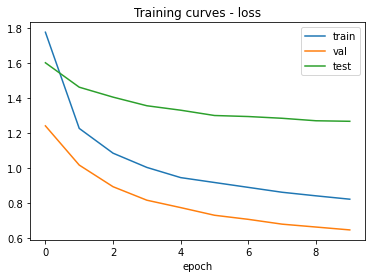

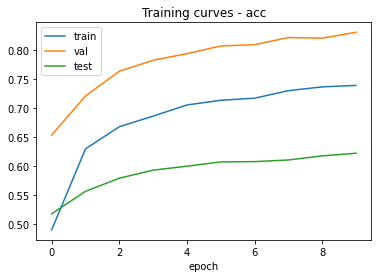

In [ ]:
plot_training_curves(training_curves_phase1, phases=['train', 'val', 'test'])

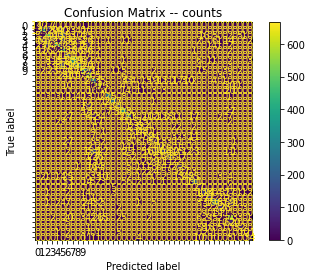

In [ ]:
# TODO: Is there a way we can have this visualization for our 43 classes?
res = plot_cm(vgg11_phase1, device, dataloaders, phase='test')

### Phase 2

Now that we are achieving decent performance, we will unfreeze all of the weights and perform a second phase of training. Now the feature extraction layers will undergo fine-tuning in addition to the last classification layer.

One thing to note is since we are performing training on all of the weights, this phase of training will take significantly longer than Phase 1.

In [ ]:
# Un-Freeze the weights of the network
for param in vgg11_phase1.parameters():
    param.requires_grad = True


In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(vgg11_phase1.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
vgg11_phase2, training_curves_phase2 = train_classification_model(vgg11_phase1, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 3.3415 Acc: 0.2104
val   Loss: 1.6088 Acc: 0.4883
test  Loss: 1.8097 Acc: 0.4386

Epoch 2/10
----------
train Loss: 0.7748 Acc: 0.7451
val   Loss: 0.3172 Acc: 0.9009
test  Loss: 0.5549 Acc: 0.8308

Epoch 3/10
----------
train Loss: 0.2469 Acc: 0.9220
val   Loss: 0.1313 Acc: 0.9604
test  Loss: 0.3992 Acc: 0.8884

Epoch 4/10
----------
train Loss: 0.1264 Acc: 0.9594
val   Loss: 0.1163 Acc: 0.9676
test  Loss: 0.4873 Acc: 0.8860

Epoch 5/10
----------
train Loss: 0.0983 Acc: 0.9695
val   Loss: 0.0918 Acc: 0.9715
test  Loss: 0.4611 Acc: 0.8982

Epoch 6/10
----------
train Loss: 0.0806 Acc: 0.9750
val   Loss: 0.0850 Acc: 0.9773
test  Loss: 0.2882 Acc: 0.9251

Epoch 7/10
----------
train Loss: 0.0580 Acc: 0.9820
val   Loss: 0.0691 Acc: 0.9805
test  Loss: 0.3158 Acc: 0.9268

Epoch 8/10
----------
train Loss: 0.0536 Acc: 0.9819
val   Loss: 0.1186 Acc: 0.9709
test  Loss: 0.5390 Acc: 0.9089

Epoch 9/10
----------
train Loss: 0.0400 Acc: 0.9870
val   Loss: 0.0550

### Visualizing Training Curves and Results

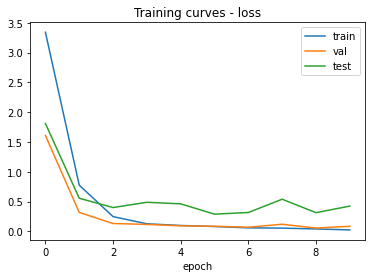

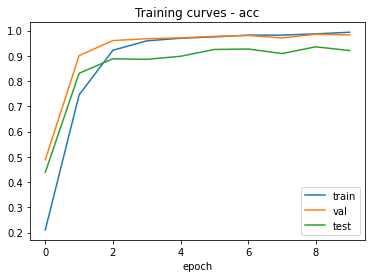

In [ ]:
plot_training_curves(training_curves_phase2, phases=['train', 'val', 'test'])

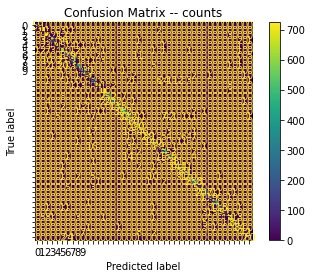

In [ ]:
res = plot_cm(vgg11, device, dataloaders, phase='test')

## Looking Ahead

We can see from the quickly achieved high performance of our model that transfer learning is an extremely powerful tool for getting good performance on new datasets very quickly. Although in our example we performed transfer learning on an image classification task, this paradigm can be used for any machine learning task.

Now that we have another Deep Learning tool in our tool belt, it is time to shift our focus away from CNN and vision related problems. In the next sections, we will investigate language and text based Deep Learning models learn how to use them to solve new and exciting problems.